<a href="https://colab.research.google.com/github/ikhlas15/ATHENS-AI-Medical-Imaging/blob/main/H13_explainability_interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 13: Explainability and Interpretability for Medical Imaging Models**

### **Course**: Artificial Intelligence in Medical Imaging: From Fundamentals to Applications

***

## 1) Introduction

As models become more accurate, the next essential step is to understand why they make specific predictions—especially in high‑stakes domains like medical imaging. Explainability and interpretability tools help you:
- Build trust by showing that a model attends to clinically relevant regions (e.g., consolidations in X‑rays).
- Debug models that might be exploiting spurious cues (e.g., laterality markers, devices, text).
- Comply with clinical governance and emerging regulatory expectations.

In this notebook you will:
- Load a chest X‑ray classifier (ResNet18) and a validation set (PneumoniaMNIST).
- Compute attributions with:
  - Integrated Gradients (feature importance at pixel level)
  - Saliency (vanilla gradients)
  - Occlusion (perturbation-based)
  - Grad‑CAM (regional importance from deep feature maps)
- Visualize and overlay attributions on images.
- Run quick sanity checks and discuss clinical best practices.

Prerequisites
- You have already trained a PneumoniaMNIST classifier (Notebook 12). If not, this notebook includes a quick “train-the-head” fallback so you can still generate meaningful attributions.

***

## 2) Setup

Install and import packages. Then set device and a reproducible seed.

In [ ]:
# Colab: safe to re-run
!pip install -q medmnist captum torchvision  # Hint: Libraries needed for dataset + model + interpretability

import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F  # Hint: For activation, interpolation, etc.
from torch.utils.data import DataLoader  # Hint: For batching datasets

import torchvision
import torchvision.transforms as T  # Hint: For resizing, normalizing, converting to tensors

from medmnist import PneumoniaMNIST  # Hint: Load the PneumoniaMNIST dataset
from captum.attr import IntegratedGradients, Saliency, Occlusion, LayerGradCam  # Hint: Explainers
from captum.attr import visualization as viz  # Hint: Optional visualization helper

# Device and seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Hint: GPU if available
def set_seed(seed=42):
    import random
    random.seed(_____)  # Hint: Use the same seed for reproducibility
    np.random.seed(_____)
    torch.manual_seed(_____)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(_____)
    torch.backends.cudnn.deterministic = _____  # Hint: Make results reproducible
    torch.backends.cudnn.benchmark = _____

set_seed(42)
print("Using device:", device)

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `pip install -q medmnist captum torchvision#Captum → PyTorch library for explainability (Grad-CAM, Saliency, Integrated Gradients…)'
Using device: cuda


***

## 3) Data and transforms

Pretrained ImageNet backbones expect 3‑channel 224×224 inputs with ImageNet normalization. We’ll take PneumoniaMNIST (grayscale 28×28) and:
- Resize to 224×224.
- Duplicate to 3 channels (grayscale→RGB).
- Normalize with ImageNet mean/std.

In [ ]:
# ImageNet-compatible transforms
imgnet_tf = T.Compose([
    T.Resize((____, ____)),  # Hint: ResNet expects 224x224 input
    T.Grayscale(num_output_channels=____),  # Hint: ResNet expects 3 channels
    T.ToTensor(),  # Hint: Convert PIL image to torch tensor
    T.Normalize(
        mean=[____, ____, ____],  # Hint: ImageNet mean
        std =[____, ____, ____]   # Hint: ImageNet std
    )
])

# Load validation dataset
val_set = PneumoniaMNIST(split='____', transform=imgnet_tf, download=____)  # Hint: 'train' or 'val'
val_loader = DataLoader(val_set, batch_size=____, shuffle=____)  # Hint: small batch for visualization
print("Validation set size:", len(val_set))


524

Helper to unnormalize for visualization:

In [ ]:

# Utilities to unnormalize and display images
IMAGENET_MEAN = torch.tensor([____, ____, ____]).view(3,1,1)
IMAGENET_STD  = torch.tensor([____, ____, ____]).view(3,1,1)

def unnormalize(img_3chw):
    # img_3chw: 3xHxW tensor
    return (img_3chw * IMAGENET_STD.to(img_3chw.device)) + IMAGENET_MEAN.to(img_3chw.device)

def show_img(t3chw, title=None):
    x = unnormalize(t3chw).clamp(0,1).permute(1,2,0).cpu().numpy()  # Hint: Convert CxHxW -> HxWxC for matplotlib
    plt.imshow(x, cmap=____)  # Hint: cmap=None for RGB
    if title: plt.title(title)
    plt.axis(____)

***

## 4) Model: load or quickly train the head

Load a ResNet18 backbone and adapt the classifier head to 2 classes (normal vs pneumonia).

- If you trained the model in Notebook 12 and saved weights, load them (uncomment the line with your path).
- Otherwise, we perform a short “train the head” phase to get reasonable attributions (a few epochs).


In [ ]:
# --- Build ResNet18 classifier ---
model = torchvision.models.resnet18(weights=____)  # Hint: 'ResNet18_Weights.DEFAULT' for pretrained, False for random

# Modify first conv layer if needed (grayscale → 3 channels already handled in transforms)
# If you wanted to do 1-channel input:
# model.conv1 = nn.Conv2d(____, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify final fully-connected layer for pneumonia detection (2 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, ____)

# Move model to device
model = model.to(device)

# Optionally, load pre-trained weights
# model.load_state_dict(torch.load('____', map_location=device))

# --- Quick head-only training ---
train_set = PneumoniaMNIST(split='____', transform=imgnet_tf, download=____)
train_loader = DataLoader(train_set, batch_size=____, shuffle=____)

# Freeze all layers except final FC
for p in model.parameters(): p.requires_grad = ____
for p in model.fc.parameters(): p.requires_grad = ____

criterion = nn.____()  # Hint: CrossEntropyLoss for classification
optimizer = torch.optim.____(model.fc.parameters(), lr=____)  # Hint: Adam optimizer

# Train the classifier head
model.train()
for epoch in range(____):  # Hint: small number like 20 epochs
    running_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.squeeze().long().to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    print(f"Epoch {epoch+1}: loss={running_loss/len(train_set):.4f}")

model.eval()  # Switch to evaluation mode

Training of classifier head (20 epochs)...
Epoch 1: loss=0.3718
Epoch 2: loss=0.2401
Epoch 3: loss=0.2129
Epoch 4: loss=0.2005
Epoch 5: loss=0.1918
Epoch 6: loss=0.1825
Epoch 7: loss=0.1845
Epoch 8: loss=0.1715
Epoch 9: loss=0.1703
Epoch 10: loss=0.1731
Epoch 11: loss=0.1672
Epoch 12: loss=0.1585
Epoch 13: loss=0.1701
Epoch 14: loss=0.1621
Epoch 15: loss=0.1581
Epoch 16: loss=0.1527
Epoch 17: loss=0.1621
Epoch 18: loss=0.1538
Epoch 19: loss=0.1553
Epoch 20: loss=0.1568


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Pred label: 1 | True label: 1


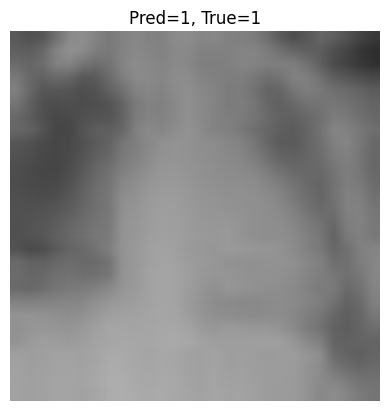

In [ ]:

# --- Make a single prediction ---
x, y = next(iter(val_loader))
x, y = x.to(device), y.squeeze().to(device)
with torch.no_grad():
    logits = model(x)
    pred = logits.argmax(dim=1)
print("Predicted:", pred.item(), "| True:", y.item())
show_img(x[0], title=f"Pred={pred.item()}, True={y.item()}")


***

## 5) Explainability methods

We will compute and visualize attributions using multiple techniques. For each, we will:
- Target the predicted class by default (you can also target the other class for contrastive analysis).
- Produce a heatmap and overlay it on the image.

### 5.1 Integrated Gradients

Integrated Gradients (IG) integrates gradients along a straight‑line path from a baseline input (e.g., zero) to the actual input.


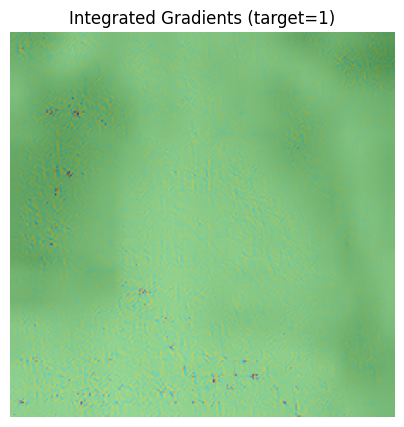

In [ ]:
ig = IntegratedGradients(model) #This attaches Integrated Gradients to the trained model.

def integrated_gradients_explain(x, target_idx):
    attributions, _ = ig.attribute(
        ...,            # TODO 1.1: the input tensor
        target= ...,       # TODO 1.2: the predicted class
        n_steps= ...,      # TODO 1.3: number of interpolation steps (e.g 50)
        baselines= ... *x,    # TODO 1.4: baseline (zero-image)
        return_convergence_delta=True
    )

    # TODO 2: Collapse RGB channels into a single heatmap
    # Hint: use mean over channel dimension (dim=1)
    heat = attributions.__(dim=1, keepdim=True)    # Normalize heatmap to [0,1] for display
    heat = heat - heat.min()
    if heat.max() > 0: heat = heat / heat.max()
    return heat

#This function shows the X-ray with colored heatmap on top.
def overlay_heatmap(x, heat, alpha=0.5, cmap='jet', title=None): #cmap='jet' → red/yellow/blue heatmap
    plt.figure(figsize=(5,5))
    # TODO 4: Convert tensor image to numpy for plotting
    # Hint: unnormalize(), clamp(), permute to HWC, then .cpu().numpy()
    base = unnormalize(x[0]).clamp(0,1)._(1,2,0). ...
    # Extract heatmap from tensor
    hm = heat[0,0].detach().cpu().numpy()
    plt.imshow(base)
    plt.imshow(hm, cmap=cmap, alpha=alpha)
    if title: plt.title(title)
    plt.axis('off'); plt.show()

# Example: IG explanation on one image
x, y = next(iter(val_loader))
x = x.to(device)

with torch.no_grad():
    logits = model(x)
    # TODO 6: get predicted class index using argmax on dim =1
    pred = logits....(dim=)
heat_ig = integrated_gradients_explain(x, target_idx=pred.item())
overlay_heatmap(x, heat_ig, alpha=0.5, title=f"Integrated Gradients (target={...})")

### 5.2 Saliency (Vanilla Gradients)

Saliency maps take the absolute value of the gradient of the output with respect to inputs. They are simple, fast, and often noisy.


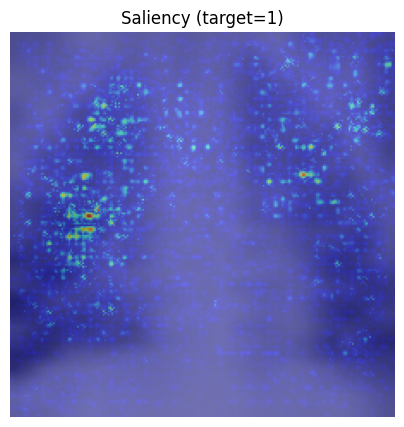

In [ ]:
sal = Saliency(model)

def saliency_explain(x, target_idx):
    x.requires_grad_() #We compute gradients with respect to model weights during training.
    #But now we want the gradient with respect to the image pixels.
    grads = sal.attribute(x, target=target_idx) # this computes ∂output(target_class) / ∂input_pixels

    # aggregate channels
    #TODO: Apply the absolute value function
    heat = grads.... .mean(dim=1, keepdim=True)
    # .mean() : Averaging channels -> one heatmap instead of 3
    heat = heat - heat.min()
    if heat.max() > 0: heat = heat/heat.max()
    x.requires_grad_(False) #Turn off gradient tracking on the input again
    return heat

x, _ = next(iter(val_loader))
# TODO: sent x to the device
x = x.
with torch.no_grad():
    logits = model(x); pred = logits.argmax(dim=1)
# TODO: Call the function
heat_sal = ...(x, target_idx=pred.item())
overlay_heatmap(x, heat_sal, alpha=0.5, title=f"Saliency (target={pred.item()})")

### 5.3 Occlusion (Perturbation-based)

Occlusion replaces small patches with a baseline (e.g., zero) and measures the change in output probability. It is intuitive and robust but computationally heavier.


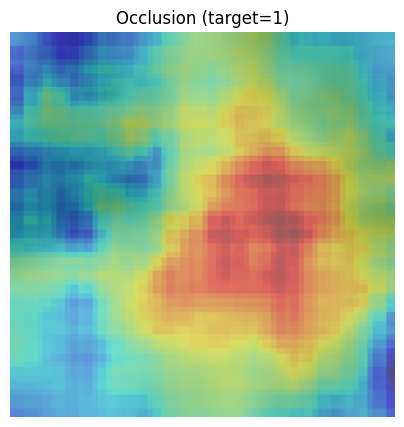

In [ ]:
occ = Occlusion(model)

def occlusion_explain(x, target_idx, window=15, stride=8):
    attrs = occ.attribute(
        x, target=target_idx,
        #occlusion works on a 3D input tensor:strides = (stride_for_channels,stride_for_height,stride_for_width)
        strides=(..., stride, stride),
        sliding_window_shapes=(..., window, window), # (3 * w * w) : This is the square that moves across the image.
        baselines=0
    )
    # Window plays the role of zoom in, stride plays the role for the resoltuion
    heat = attrs.mean(dim=1, keepdim=True)
    heat = heat - heat.min()
    if heat.max() > 0: heat = heat/heat.max()
    return heat

x, _ = next(iter(val_loader))
x = x.to(device)
with torch.no_grad():
    logits = model(x); pred = logits.argmax(dim=1)
# TODO: Call the function with window size = 19
heat_occ =
overlay_heatmap(x, heat_occ, alpha=0.5, title=f"Occlusion (target={pred.item()})")

### 5.4 Grad‑CAM (Layer attribution)

Grad‑CAM uses the gradients of a target class flowing into the last convolutional layer to produce a coarse localization map.

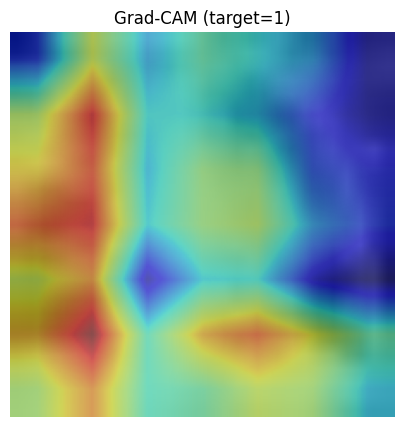

In [ ]:
# Use the last conv layer in ResNet18 (layer4[-1].conv2)
layer = model. ...
gc = LayerGradCam(model, layer)

def gradcam_explain(x, target_idx):
    #TODO: Use gc.attribute
    cam = ...(x, target=target_idx)  # 1xCxHxW (C is channels of layer)
    cam = cam.mean(dim=1, keepdim=True)
    # Upsample to input size
    cam_up = F.interpolate(cam, size=x.shape[2:], mode='bilinear', align_corners=False)
    # TODO : Normalize CAM to [0, 1]
    # Hint: subtract min, divide by max (only if > 0)
    cam_up = cam_up - cam_up.__________()
    if cam_up.__________() > 0:
        cam_up = cam_up / cam_up.__________()

    return cam_up

x, _ = next(iter(val_loader))
x = x.to(device)
with torch.no_grad():
    logits = model(x); pred = logits.argmax(dim=1)
heat_cam = gradcam_explain(x, target_idx=pred.item())
overlay_heatmap(x, ..., alpha=0.5, title=f"Grad-CAM (target={})")

***

## 6) Compare explanations per sample

Run all methods on the same case and compare qualitatively.


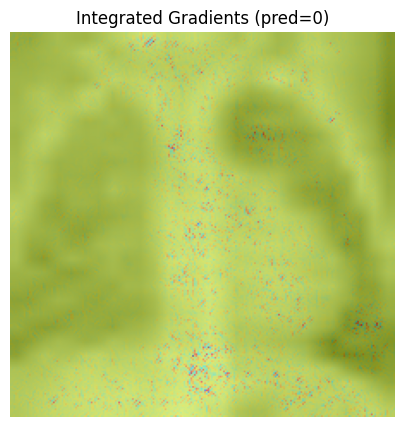

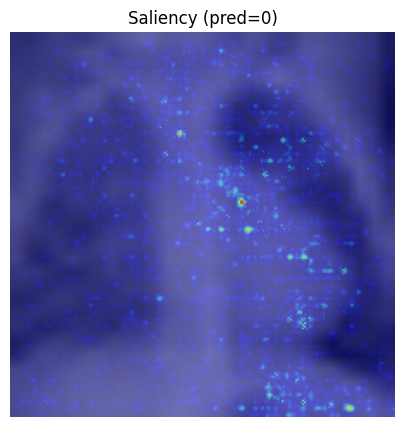

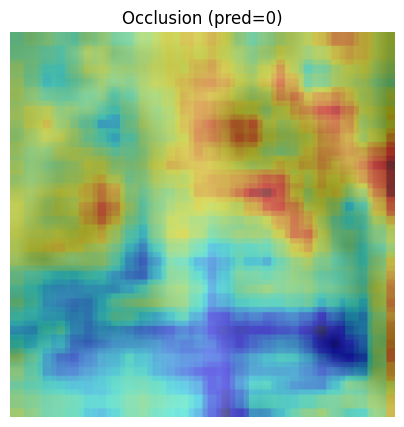

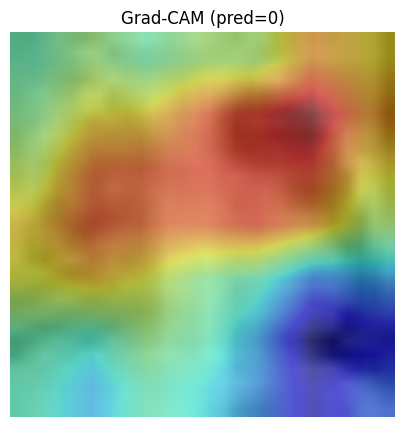

In [ ]:
x, y = next(iter(val_loader))
x = x.to(device)
with torch.no_grad():
    logits = model(x); pred = logits.argmax(dim=1).item()

h_ig  = integrated_gradients_explain(x, pred)
h_sal = saliency_explain(x, pred)
h_occ = occlusion_explain(x, pred, window=19, stride=8)
h_cam = gradcam_explain(x, pred)

overlay_heatmap(x, ...,  title=f"Integrated Gradients (pred={pred})")
overlay_heatmap(x, ... , title=f"Saliency (pred={pred})")
overlay_heatmap(x, ... , title=f"Occlusion (pred={pred})")
overlay_heatmap(x, ... , title=f"Grad-CAM (pred={pred})")

Tips:
- Pixelwise methods (Saliency, IG) can be noisy but precise.
- Region methods (Grad‑CAM, Occlusion) often highlight larger, clinically intuitive areas.
- When they agree (e.g., both focus on a suspected consolidation), your confidence increases.

***

## 7) Sanity checks and pitfalls

Attribution methods can be misleading if:
- The model has not learned meaningful features yet (random or poorly trained).
- Explanations are insensitive to model parameters (a red flag).

Two quick checks:

1) Randomized model sanity check: explanations should change substantially if you randomize the model weights.

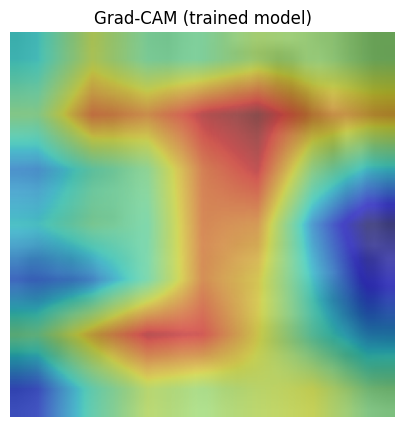

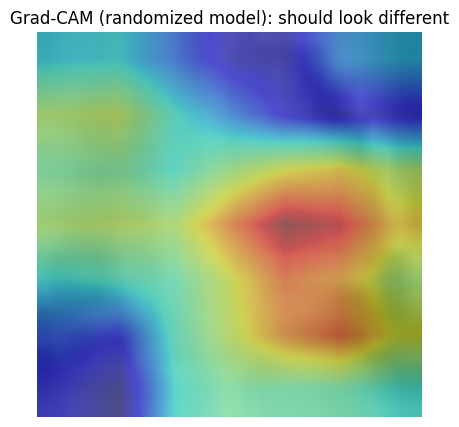

In [ ]:
def copy_model(m):
    import copy
    return copy.deepcopy(m)
# This function makes a complete clone of your model.
# Same structure, same weights, fully separate object.

#This turns the model into a totally untrained model.
def randomize_weights(m):
    for n, p in m.named_parameters(): #For each parameter p in the model:
        if p.requires_grad and p.dim() > 1: #If that parameter can be trained and it is a weight matrix (biases are 1D → we skip them)
            nn.init.kaiming_normal_(p) #Then we randomly re-initialize it.

# Original attribution
x, _ = next(iter(val_loader)); x = x.to(device)
with torch.no_grad(): pred = model(x).argmax(dim=1).item()
h_original = gradcam_explain(x, pred)


m_rand = copy_model(model)
# TODO 1: Randomize the weights of the cloned model
# Hint: call the randomize_weights function on m_rand
__________(__________)
m_rand.eval().to(device)


# Recompute attribution with randomized model
gc_rand = LayerGradCam(m_rand, m_rand.layer4[-1].conv2)
# TODO 2: Compute Grad-CAM for the randomized model
cam_rand = gc_rand.attribute(
    ________,              # TODO 2.1: the input image
    target=________        # TODO 2.2: the predicted class index
).mean(
    dim=________,          # TODO 2.3: reduce channels
    keepdim=True
)
cam_rand = F.interpolate(cam_rand, size=x.shape[2:], mode='bilinear', align_corners=False)
cam_rand = cam_rand - cam_rand.min()
if cam_rand.max() > 0: cam_rand = cam_rand / cam_rand.max()

# Visual compare
overlay_heatmap(x, ..., title="Grad-CAM (trained model)")
overlay_heatmap(x, ...,  title="Grad-CAM (randomized model): should look different")

2) Targeted contrast: try explaining both the predicted class and the opposite class, well‑trained models should show different patterns.


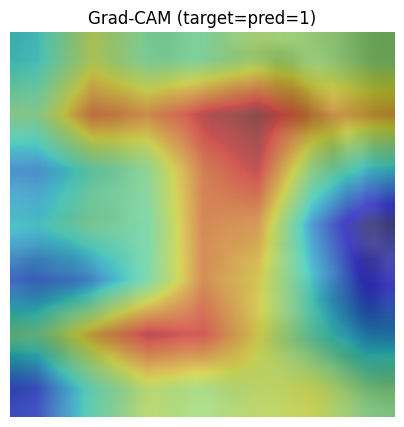

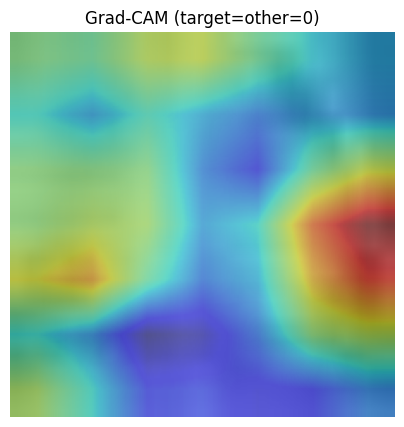

In [ ]:
target_pred = pred
target_other = 1 - ...

h_pred  = gradcam_explain(x, target_pred)
h_other = gradcam_explain(x, ...)
overlay_heatmap(x, h_pred,  title=f"Grad-CAM (target=pred={target_pred})")
overlay_heatmap(..., ..., title=f"Grad-CAM (target=other={target_other})")

***

## 8) Batch visualization (attention gallery)

See multiple cases at once to look for systematic issues (e.g., focus on text, edges, devices).

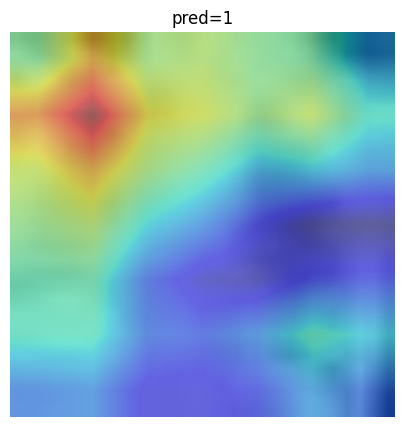

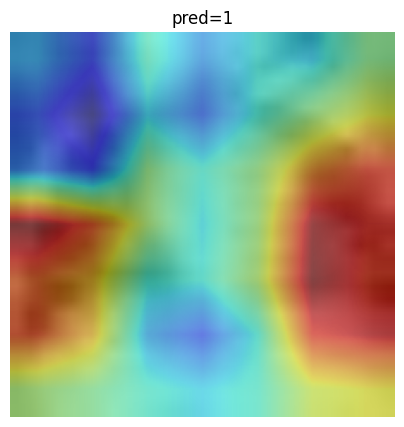

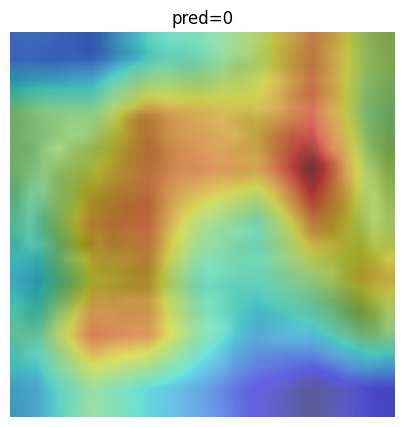

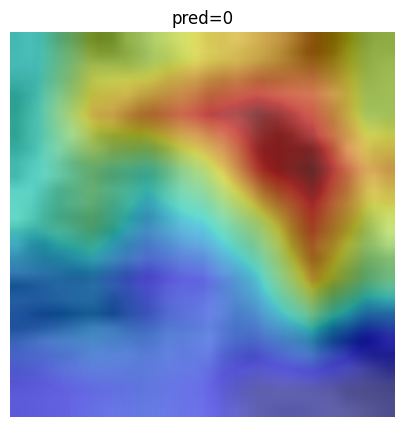

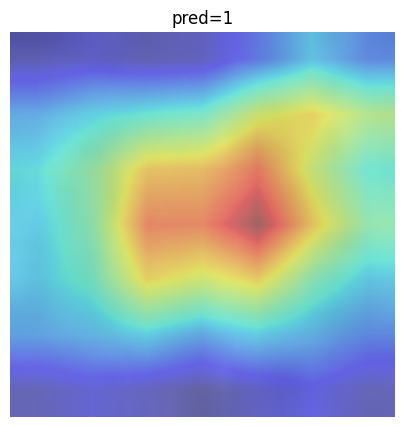

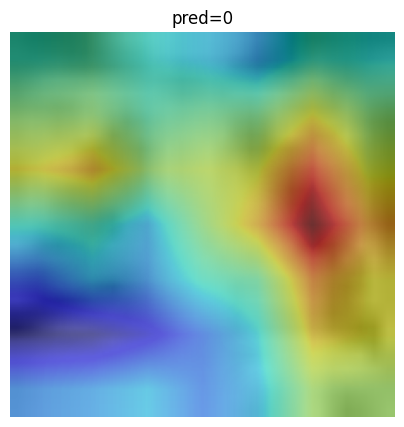

In [ ]:
def show_batch_gradcam(n=6):
    model.eval()
    shown = 0
    for xb, yb in val_loader:
        xb = xb.to(device)
        with torch.no_grad():
          # TODO 1: Compute predictions for the whole batch
            pred = ... .argmax(dim=1)
        for i in range(xb.size(0)):
          # TODO 2: Compute Grad-CAM on a single image
            # Hint: keep batch dimension → xb[i:i+1]
            heat = gradcam_explain(
                ____________,                  # TODO 2.1: slice with [i:i+1]
                target_idx=__________          # TODO 2.2: predicted class for this image
            )
            shown += 1
            if shown >= n: return #Stop after showing n images

# TODO 4: Call the function to display a few Grad-CAM results
show_batch_gradcam(n= )

***

## 9) Clinical considerations and best practices

- Validate that highlighted regions align with known imaging signs of disease (e.g., lobar consolidation or diffuse opacities for pneumonia).
- Check for spurious correlations:
  - Laterality markers, text, borders, devices (catheters, tubes), or positioning artifacts.
  - If explanations consistently emphasize non‑anatomical regions, revisit preprocessing, augmentation, and data curation.
- Combine with robust evaluation:
  - Use the metrics from Notebook 09 (ROC, PR, sensitivity/specificity at clinical thresholds).
  - Perform error analysis: inspect false positives and false negatives with explanations.
- Stabilize attributions:
  - SmoothGrad (averaging over noisy inputs), IG with multiple baselines, or using region‑based methods can reduce noise.
- Transparency in reporting:
  - Include example explanations for typical, edge, and failure cases in your report.

***
## 10) Summary


Where to go next
- Add SmoothGrad to reduce noise in Saliency/IG.
- Try Grad‑CAM++ or Score‑CAM variants.
- Use explanation‑guided debugging: identify spurious features and mitigate them via preprocessing, augmentation, or dataset edits.
- Integrate explanations into validation workflows so clinicians can review them alongside predictions.

This completes the core hands‑on journey from fundamentals to interpretable medical AI.
